<font size = "5"> **Chapter 4:  [Spectroscopy](Ch4-Spectroscopy.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss Spectra
<br>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/master/notebooks/EELS/Analysis_Core_Loss.ipynb)

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>


by Gerd Duscher, 2020

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Install the newest version of sidpy
This notebook will only run with  ``version 0.0.3`` or higher.

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1
    
    This test does not require a loading of the packages
    """
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyNSID/ -q
    !pip install git+https://github.com/pycroscopy/sidpy/ -q
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q
else:
    # pyTEMlib setup ------------------
    if test_package('pyTEMlib') < '0.2021.1.6':
        !{sys.executable} -m pip install  --upgrade git+https://github.com/pycroscopy/pyTEMlib -q
        print('installed pyTEMlib')
    if test_package('sidpy') < '0.0.4':
        !{sys.executable} -m pip install  --upgrade sidpy -q
        print('installed sidpy')
    if test_package('pyNSID') < '0.0.1':
        !{sys.executable} -m pip install  --upgrade  git+https://github.com/pycroscopy/pyNSID -q
        print('Installed pyNSID')
# ------------------------------
print('done')

installed pyTEMlib
done


## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## First we import the relevant packages

In [3]:
import sys
if 'google.colab' in sys.modules:
    import numpy as np
else:    
    %pylab --no-import-all notebook
    %gui qt
%load_ext autoreload 
%autoreload 2
sys.path.insert(0,'../../')
# Import libraries from pyTEMlib
import sidpy
import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 
import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification
import pyTEMlib.viz

import colab_plot

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2021_01_04'

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2021.01.05b


%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../pyTEMlib/')

## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


In [4]:
# ---- INPUT choices ---- #
Open_Nion_Directory = False  
bokeh_plot = True  # using bokeh to plot or not
# ------------------------#

drive_directory = ft.get_last_path()
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    Open_Nion_Directory = True
    drive_directory = 'drive/MyDrive/'
    bokeh_plot = True
elif not ft.QT_available:
    Open_Nion_Directory = True    

if bokeh_plot == True:
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.models import LinearAxis, Range1d
    output_notebook()

### Open file widget
if Open_Nion_Directory:
    file_widget = pyTEMlib.file_tools.FileWidget(drive_directory)

Loading BokehJS ...

In [23]:
try:
    current_dataset.h5_dataset.file.close()
except:
    pass

current_dataset = ft.open_file('EELS_STO.dm3')
#current_dataset = ft.open_file()

current_channel = current_dataset.h5_dataset.parent

if 'experiment' not in current_dataset.metadata:
    current_dataset.metadata['experiment']= eels.read_dm3_eels_info(current_dataset.original_metadata)
# US 200 does not set acceleration voltage correctly.
# comment out next line  for other microscopes
# current_dataset.metadata['experiment']['acceleration_voltage'] = 200000
ft.QT_available = False
if ft.QT_available:
    info = ieels.InfoDialog(current_dataset)
else:
    print('make sure information is correct')
    current_dataset.view_metadata()

    p = pyTEMlib.viz.plot_spectrum(current_dataset)
    show(p)

Cannot overwrite file. Using:  EELS_STO-9.hf5
make sure information is correct
experiment :
	single_exposure_time : 2.0
	exposure_time : 20.0
	number_of_frames : 10
	collection_angle : 33.0
	convergence_angle : 30.0
	acceleration_voltage : 200000.0
	microscope : Unknown


C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:349: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

In [ ]:
def update_element(z, edges):

    zz = eels.get_z(z)
    index = 0
    for key, edge in edges.items():
        if 'Z' in edge:
            index += 1
            if zz == edge['Z']:
                return None

    major_edge = ''
    minor_edge = ''
    all_edges = {}
    x_section = eels.get_x_sections(zz)
    edge_start = 10  # int(15./ft.get_slope(self.energy_scale)+0.5)
    for key in x_section:
        if len(key) == 2 and key[0] in ['K', 'L', 'M', 'N', 'O'] and key[1].isdigit():
            if self.energy_scale[edge_start] < x_section[key]['onset'] < self.energy_scale[-edge_start]:
                if key in ['K1', 'L3', 'M5']:
                    major_edge = key
                elif key in ['K1', 'L3', 'M5', 'M3', 'M1', 'N1', 'N3', 'N5', 'N7', 'O1', 'O3', 'O5']:
                    if minor_edge == '':
                        minor_edge = key
                    if int(key[-1]) % 2 > 0:
                        if int(minor_edge[-1]) % 2 == 0 or key[-1] > minor_edge[-1]:
                            minor_edge = key

                all_edges[key] = {'onset': x_section[key]['onset']}

    if major_edge != '':
        key = major_edge
    elif minor_edge != '':
        key = minor_edge
    else:
        print(f'Could not find no edge of {zz} in spectrum')
        return False



    start_exclude = x_section[key]['onset'] - x_section[key]['excl before']
    end_exclude = x_section[key]['onset'] + x_section[key]['excl after']

    edges[str(index)] = {'Z': zz, 'symmetry': key, 'element': eels.elements[zz],
                          'onset': x_section[key]['onset'], 'end_exclude': end_exclude,
                          'start_exclude': start_exclude}
    edges[str(index)]['all_edges'] = all_edges
    edges[str(index)]['chemical_shift'] = 0.0
    edges[str(index)]['areal_density'] = 0.0
    edges[str(index)]['original_onset'] = edges[str(index)]['onset']
    return True

In [47]:
# current_dataset.metadata['edges'] = {'0': {}, 'model': {}}
element_list= ['Ti', 'O']
if ft.QT_available:
    composition = ieels.CompositionDialog(current_dataset)
else:
    if 'edges' not in current_dataset.metadata or current_dataset.metadata['edges'] == {}:
        current_dataset.metadata['edges'] = {'0': {}, 'model': {}}
    edges = current_dataset.metadata['edges']
    edges['fit_area'] = {'fit_start': current_dataset.energy_loss[50],
                              'fit_end': current_dataset.energy_loss[-2]}
    
    print('Adjust onset and exclude parameters for each edge in dictionary current_dataset.metadata[\'edges\']')
    i = 0
    for element in element_list:
        update_element(element, edges)
        print(f"{edges[str(i)]['element']:2s}: edges[\'{i}\'][\'onset\']: {edges[str(i)]['onset']}; "+
              f" edges[\'{i}\'][\'start_exclude\']: {edges[str(i)]['start_exclude']}; "+
              f" edges[\'{i}\'][\'end_exclude\'] {edges[str(i)]['end_exclude']} ")
        i+=1
        


Adjust onset and exclude parameters for each edge in dictionary current_dataset.metadata['edges']
Ti: edges['0']['onset']: 455.5;  edges['0']['start_exclude']: 450.5;  edges['0']['end_exclude'] 505.5 
O : edges['1']['onset']: 532.0;  edges['1']['start_exclude']: 527.0;  edges['1']['end_exclude'] 582.0 


In [96]:
def do_fit(dataset):
    if 'experiment' in dataset.metadata:
        exp = dataset.metadata['experiment']
        if 'convergence_angle' not in exp:
            raise ValueError('need a convergence_angle in experiment of metadata dictionary ')
        alpha = exp['convergence_angle']
        beta = exp['collection_angle']
        beam_kv = exp['acceleration_voltage']
    else:
        raise ValueError('need a experiment parameters in metadata dictionary')
    if 'edges' in dataset.metadata:
        edges = dataset.metadata['edges']
    else:
        raise ValueError('need a edge parameters in metadata dictionary')
    energy_scale = dataset.energy_loss.values
    eff_beta = eels.effective_collection_angle(energy_scale, alpha, beta, beam_kv)

    edges = eels.make_cross_sections(edges, np.array(energy_scale), beam_kv, eff_beta)

    if dataset.data_type == sidpy.DataType.SPECTRAL_IMAGE:
        spectrum = self.dataset.view.get_spectrum()
    else:
        spectrum = dataset
    edges = eels.fit_edges2(spectrum, energy_scale, edges)
    areal_density = []
    elements = []
    for key in edges:
        if key.isdigit():  # only edges have numbers in that dictionary
            elements.append(edges[key]['element'])
            areal_density.append(edges[key]['areal_density'])
    areal_density = np.array(areal_density)
    out_string = '\nRelative composition: \n'
    for i, element in enumerate(elements):
        out_string += f'{element}: {areal_density[i] / areal_density.sum() * 100:.1f}%  '
    print(out_string)
    dataset.metadata['add2plot'] = {}
    dataset.metadata['add2plot'][1] = {'data': edges['model']['spectrum'], 'legend': 'model'} 
    dataset.metadata['add2plot'][2] = {'data': np.array(spectrum - edges['model']['spectrum']), 'legend': 'difference'} 

    dataset.metadata['add2plot'][3] = {'data': np.array((spectrum-edges['model']['spectrum'])/np.sqrt(spectrum)), 
                                       'legend':'Poisson'}
if not ft.QT_available:
    
    do_fit(current_dataset)   
    p = pyTEMlib.viz.plot_spectrum(current_dataset)
    show(p)




Relative composition: 
Ti: 22.5%  O: 77.5%  


In [70]:
current_dataset.view_metadata()

experiment :
	single_exposure_time : 2.0
	exposure_time : 20.0
	number_of_frames : 10
	collection_angle : 33.0
	convergence_angle : 30.0
	acceleration_voltage : 200000.0
	microscope : Unknown
edges :
	0 :
		Z : 22
		symmetry : L3
		element : Ti
		onset : 455.5
		end_exclude : 505.5
		start_exclude : 450.5
		all_edges :
			L3 :
				onset : 455.5
			L2 :
				onset : 461.5
			L1 :
				onset : 563.6999999999999
		chemical_shift : 0.0
		areal_density : 8575408383826.057
		original_onset : 455.5
		data : [9.75030543e-10 9.72936517e-10 9.70842492e-10 ... 4.76621339e-10
 4.76045667e-10 4.75469995e-10]
		X_section_type : XRPA
		X_section_source : pyTEMlib
	model :
		background : [171526.50121499 171263.37441496 171000.78053871 ...  14846.70263466
  14833.72608114  14820.77211068]
		background-poly_0 : -393.0904560088103
		background-poly_1 : -68.62668329989688
		background-poly_2 : 0.053673353013315495
		background-A : 12172261631.904371
		background-r : 1.8899156398038295
		spectrum : [185788.

### Output of Results

In [71]:
edges = current_dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])

print('Relative chemical composition of ', current_dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges

Relative chemical composition of  EELS_STO
Ti: 22.5 %
O: 77.5 %


### Log Data
We write all the data to the hdf5 file associated with our dataset.

In our case that is only the ``metadata``, in which we stored the ``experimental parameters`` and the ``fitting parameters and result``.

In [74]:
current_group = current_dataset.h5_dataset.parent.parent
if 'Log_000' not in current_group:
    log_group = current_group.create_group('Log_000')
    
log_group = current_group['Log_000']
if 'analysis' in log_group:
    del log_group['analysis'] 
log_group['analysis'] = 'EELS_quantification'
metadata = ft.flatten_dict(current_dataset.metadata)
for key, item in metadata.items():
    log_group.attrs[key]= item
current_group.file.flush()

In [75]:
ft.h5_tree(current_group.file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ EELS_STO
      --------
      ├ EELS_STO
      ├ Log_000
        -------
        ├ analysis
      ├ __dict__
        --------
      ├ _axes
        -----
      ├ _original_metadata
        ------------------
      ├ energy_loss
      ├ original_metadata
        -----------------
    ├ Log_000
      -------
      ├ analysis


## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (2 iterations are ususally sufficient) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).


<IPython.core.display.Javascript object>


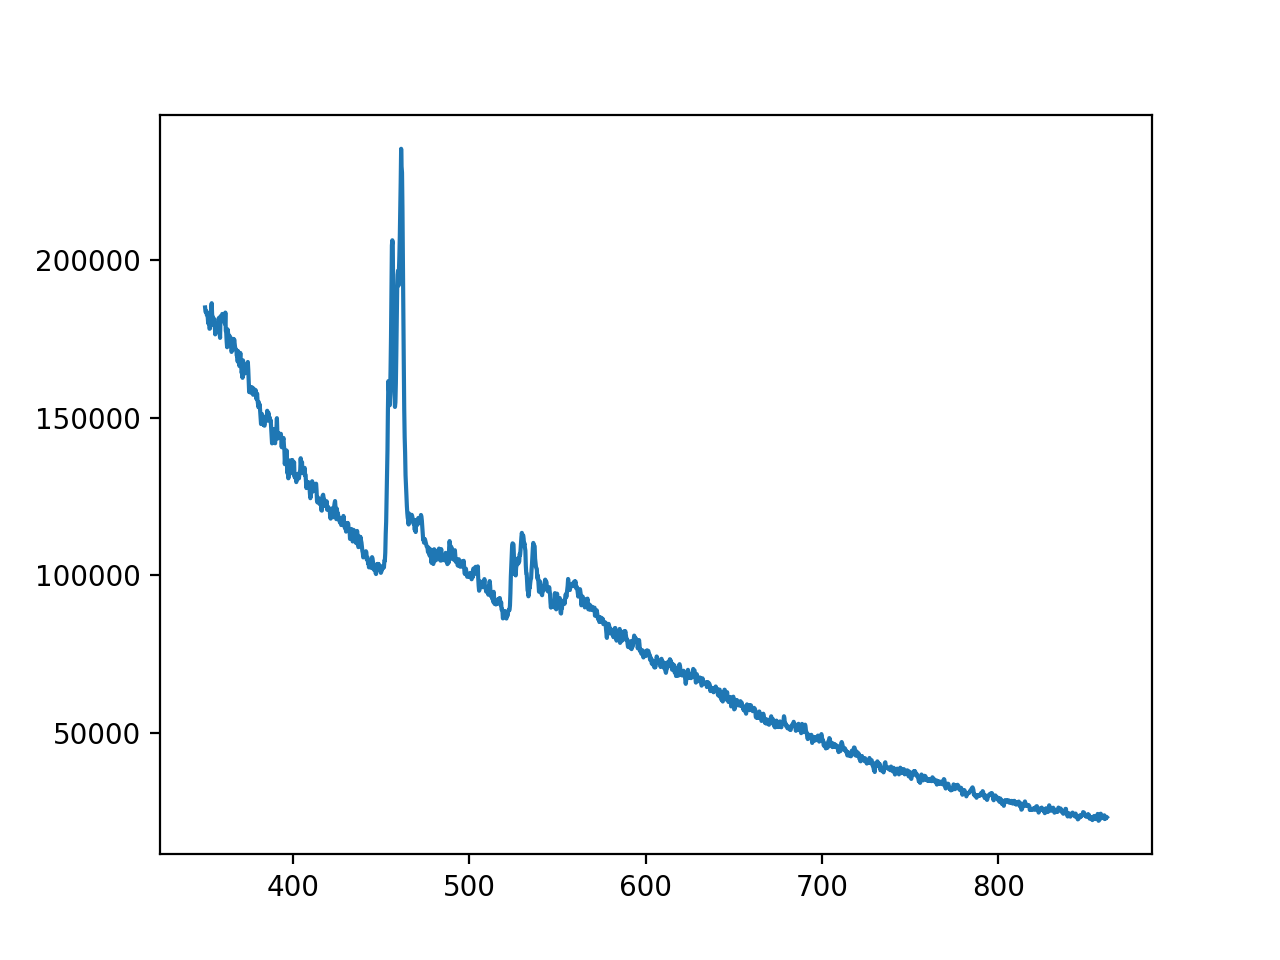

In [77]:
if not ft.QT_available:
    
    do_fit(current_dataset)   
    p = pyTEMlib.viz.plot_spectrum(current_dataset)
    show(p)peak_dialog = ieels.PeakFitDialog(current_dataset)

In [88]:
print(current_dataset.metadata['peak_fit'].keys())
print(current_dataset.metadata['edges']['model']['spectrum'])

dict_keys(['fit_start', 'fit_end', 'peaks'])
[185788.16041277 185492.62706014 185197.62663128 ...  22720.89817064
  22698.26256964  22675.64955171]


In [95]:
if  ft.QT_available:
    peak_dialog = ieels.PeakFitDialog(current_dataset)
else: 
    if 'peak_fit' not in current_dataset.metadata:
        current_dataset.metadata['peak_fit'] = {'fit_start': current_dataset.energy_loss[1],
                                                'fit_end': current_dataset.energy_loss[-2]}
    peaks = current_dataset.metadata['peak_fit'] 
    if 'edges' not in current_dataset.metadata:
        print('You need to do the quantification first')
    if 'model'  in current_dataset.metadata['edges']:
        if 'spectrum' not in current_dataset.metadata['edges']['model']:
            print('You need to do the quantification first')
        else:
            model = current_dataset.metadata['edges']['model']['spectrum']

    peak_model, peak_out_list = eels.find_peaks(current_dataset, peaks['fit_start'],
                                                                 peaks['fit_end'])
    peak_out_list = [peak_out_list]
    spec_dim = ft.get_dimensions_by_type('SPECTRAL', current_dataset)[0]
    current_dataset.metadata['peak_fit']['edge_model'] = model
    model = model + peak_model
    current_dataset.metadata['peak_fit']['peak_model'] = peak_model
    current_dataset.metadata['peak_fit']['peak_out_list'] = peak_out_list

    current_dataset.metadata['add2plot'] = {}
    current_dataset.metadata['add2plot'][1] = {'data': model, 'legend': 'model'} 
    current_dataset.metadata['add2plot'][2] = {'data': np.array(current_dataset-model), 'legend': 'difference'} 

    current_dataset.metadata['add2plot'][3] = {'data': np.array((current_dataset-model)/np.sqrt(current_dataset)), 
                                           'legend':'Poisson'}

    p = pyTEMlib.viz.plot_spectrum(current_dataset)
    show(p)

In [62]:
print(peak_dialog.peak_da)

for key in peak_dialog.peaks['peaks']:
    if key.isdigit():
        print(key)
        
print(peak_dialog.peaks['peaks'])
current_dataset.metadata['peak_fit']['peaks'].keys()

True
0
{'0': {'position': 707.5, 'amplitude': 1000.0, 'width': 1.0, 'type': 'Gauss', 'asymmetry': 0}}


dict_keys(['0'])

### Output

In [50]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

peak  0: position:   887.5, area:  1108828.834 associated edge: 
peak  1: position:   905.5, area:  1318287.152 associated edge: 
peak  2: position:   859.9, area:    79451.959 associated edge: 
peak  3: position:  1569.2, area:    58924.095 associated edge: 
peak  4: position:  1183.9, area:   104840.196 associated edge: 


### Log Data

In [14]:
current_group = current_dataset.h5_dataset.parent
if 'Log_001' not in current_group:
    log_group = current_group.create_group('Log_001')
    
log_group = current_group['Log_001']
if 'analysis' in log_group:
    del log_group['analysis'] 
log_group['analysis'] = 'ELNES_fit'
metadata = ft.flatten_dict(current_dataset.metadata)
for key, item in metadata.items():
    log_group.attrs[key]= item
current_group.file.flush()

print('Logged Data of ', current_dataset.title)
for key in current_group:
    if 'Log_' in key:
        if 'analysis' in current_group[key]:
            print(f" {key}: {current_group[key]['analysis'][()]}")

Logged Data of  01_EELS Acquire_STO
 Log_000: EELS_quantification
 Log_001: ELNES_fit


## Close File
File needs to be closed to be used with other notebooks

In [15]:
current_dataset.h5_dataset.file.close()

## Navigation
<font size = "5"> **Back: [Calculating Dielectric Function II: Silicon](DielectricDFT2.ipynb)** </font>

<font size = "5"> **Next: [ELNES](ELNES.ipynb)** </font>

<font size = "5"> **Chapter 4: [Spectroscopy](Spectroscopy.ipynb)** </font>

<font size = "5"> **Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)** </font>